In [23]:
import os
import random
import itertools
import re

# 基本的なライブラリ
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats

# 描画ライブラリ
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn_analyzer import CustomPairPlot
import graphviz
import pydotplus
from IPython.display import Image
from IPython.display import HTML
from six import StringIO
from ipywidgets import interact, FloatSlider
from dtreeviz.trees import *

# データセット分割
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit

# 補完
from sklearn.experimental import (
    enable_iterative_imputer,
)  # IterativeImputerをimportするために必要
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

# エンコード
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder

# サンプリング
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# 特徴量選択
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import (
    GenericUnivariateSelect,
    f_classif,
    mutual_info_classif,
    chi2,
)
from boruta import BorutaPy
from libraries.mrmr import mrmr

# 学習中
import optuna
from tqdm import tqdm
from sklearn.model_selection import learning_curve, cross_validate, cross_val_score

# 評価指標
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# models
from lightgbm import LGBMClassifier

# XAI
import shap

import warnings


# config python file
import config

SEED = config.SEED

from functions import *

fix_seed(SEED)


# 最大表示列数の指定（ここでは50列を指定）N
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 50)

%matplotlib inline

# データ読み込み

In [24]:
X_dict = pickle_load(
    config.INTERIM_PICKLE_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/X_dict.pickle"
)
y_dict = pickle_load(
    config.INTERIM_PICKLE_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/y_dict.pickle"
)

In [31]:
X_train = X_dict["genes"]["mrmr"]["train"]["X15"]
y_train = y_dict["genes"]["mrmr"]["train"]["y15"]
X_val = X_dict["genes"]["mrmr"]["val"]["X15"]
y_val = y_dict["genes"]["mrmr"]["val"]["y15"]
X_test = X_dict["genes"]["mrmr"]["test"]["X15"]
y_test = y_dict["genes"]["mrmr"]["test"]["y15"]

assert X_train.shape[0] == y_train.shape[0], "train size is incorrect"
assert X_val.shape[0] == y_val.shape[0], "val size is incorrect"
assert X_test.shape[0] == y_test.shape[0], "test size is incorrect"
assert X_train.shape[1] == X_test.shape[1], "feature size is incorrect"

X_train = pd.concat([X_train, X_val])
y_train = pd.concat([y_train, y_val])

# accuracyの表示
print("----------" * 10)
print("使用特徴量：", X_train.columns)
print("学習サンプルサイズ：", X_train.shape)
display("ラベル比率：", y_train.value_counts())

----------------------------------------------------------------------------------------------------
使用特徴量： Index(['RACGAP1', 'TBC1D24', 'ARTN', 'LIN7A', 'IGFBP5', 'ANGPT2', 'HAMP',
       'UTP23', 'RBBP8', 'STAT5B', 'C9orf95', 'FGF13', 'RNU11', 'ENC1', 'AK3',
       'NEIL2', 'CS', 'S100P', 'FGD3', 'IL20RA', 'WDR67', 'C2orf74',
       'HIST1H2BF', 'ADCK2', 'PREX1', 'INTS10', 'ZIC2', 'DPM3', 'SUSD3',
       'PPIL3', 'RND1', 'GSTM2', 'KIAA1967', 'COX7B2', 'SPATA18'],
      dtype='object')
学習サンプルサイズ： (950, 35)


'ラベル比率：'

1    509
0    441
Name: OS_15years, dtype: int64

# モデル作成 (all data)

## Random Forest

In [32]:
params = {
    "n_estimators": 70,
    "max_depth": 42,
    "max_leaf_nodes": 62,
    "class_weight": "balanced",
    "random_state": SEED,
}
rf = RandomForestClassifier(**params)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

show_scores(y_test, y_pred)

accuracy:  0.6792452830188679
precision:  0.6885245901639344
recall:  0.7368421052631579
f1 score:  0.7118644067796609


### dtree

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


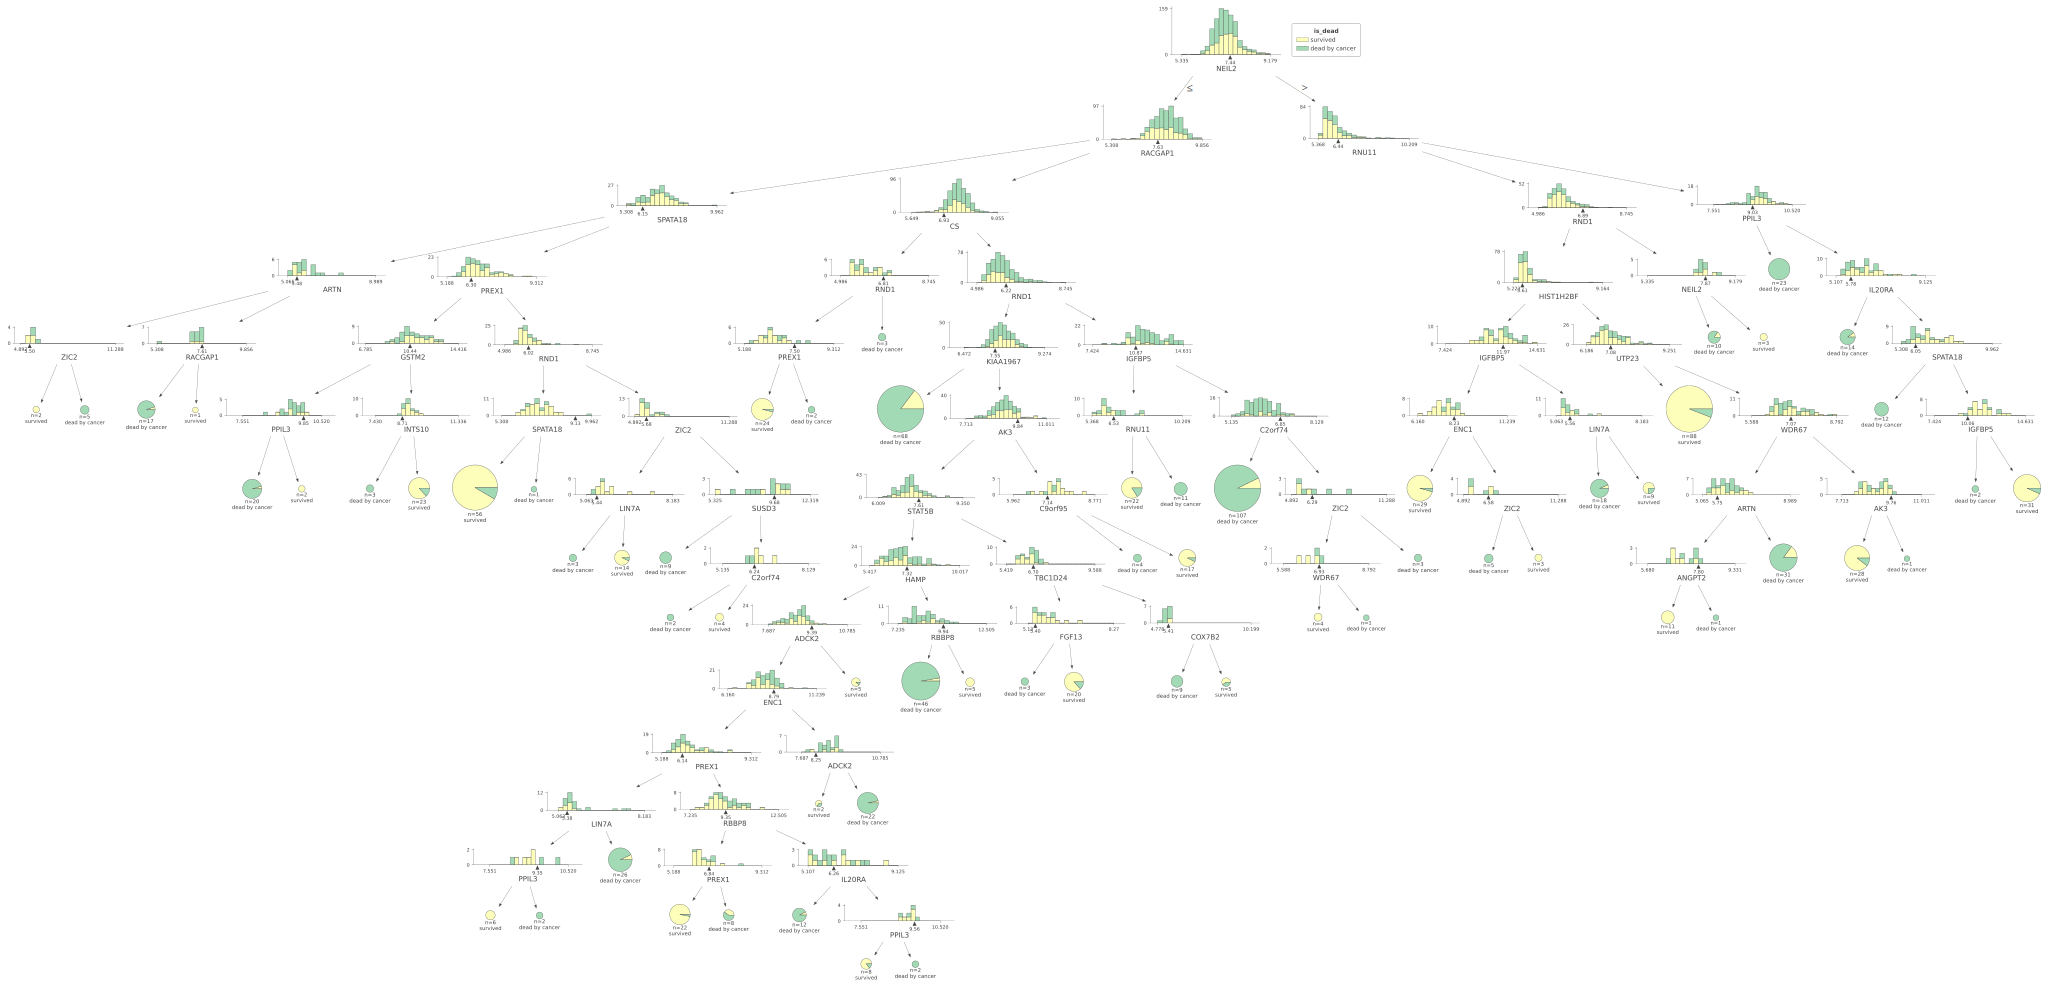

In [33]:
viz = dtreeviz(
    rf.estimators_[1],
    X_train,
    y_train,
    feature_names=X_train.columns,
    target_name="is_dead",
    class_names=["survived", "dead by cancer"],
)
viz

### shap

In [34]:
# load JS visualization code to notebook
shap.initjs()
# Create object that can calculate shap values
explainer = shap.TreeExplainer(rf)
# Calculate SHAP values
shap_values = explainer.shap_values(X_train)

shap.force_plot(explainer.expected_value[0], shap_values[0])

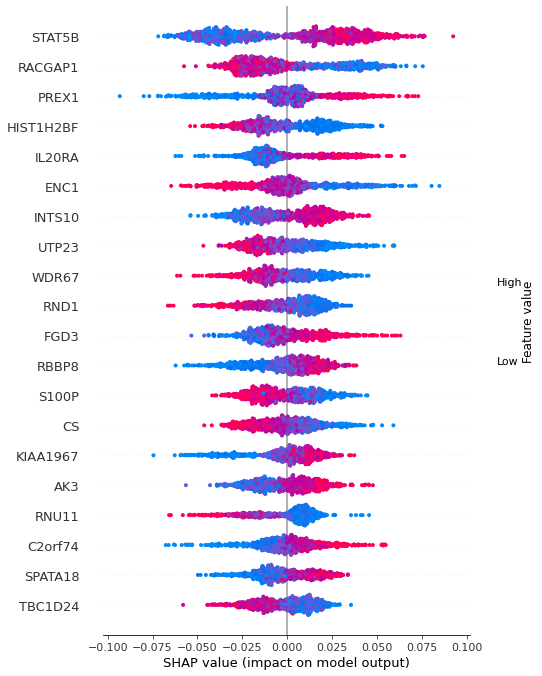

In [35]:
shap.summary_plot(shap_values[0], X_train, show=False)
plt.tight_layout()
plt.savefig("shap_values.jpeg")

## Logistic Regression

In [36]:
params = {
    "penalty": "l2",
    "C": 13670.65897712823,
    "class_weight": "balanced",
    "random_state": SEED,
}
lr = LogisticRegression(**params)

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

show_scores(y_test, y_pred)

accuracy:  0.7264150943396226
precision:  0.75
recall:  0.7368421052631579
f1 score:  0.743362831858407


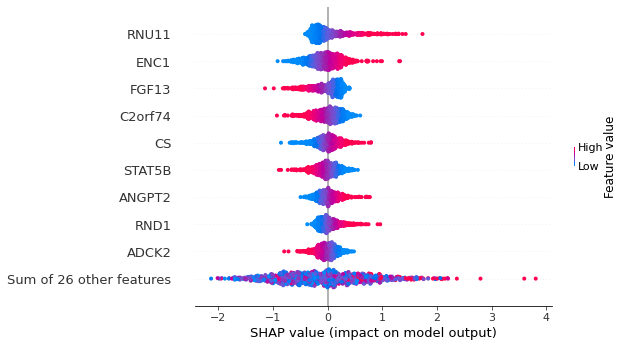

In [37]:
# load JS visualization code to notebook
shap.initjs()
# Create object that can calculate shap values
explainer = shap.Explainer(lr, X_train, feature_names=X_train.columns)
shap_values = explainer(X_train)
shap.plots.beeswarm(shap_values)

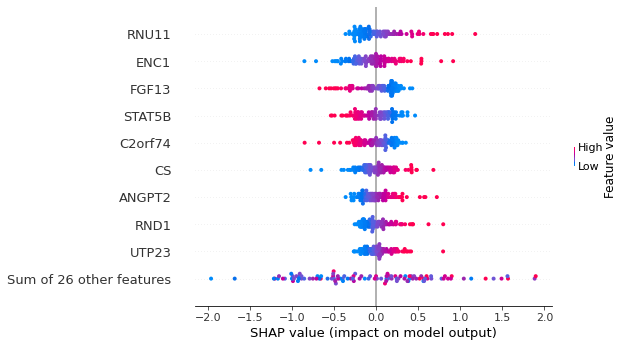

In [38]:
# load JS visualization code to notebook
shap.initjs()
# Create object that can calculate shap values
explainer = shap.Explainer(lr, X_train, feature_names=X_train.columns)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values)

## SVM

In [39]:
params = {
    "C": 31653.691881778464,
    "kernel": "linear",
    "gamma": "scale",
    "shrinking": False,
    "decision_function_shape": "ovr",
    "class_weight": "balanced",
    "random_state": SEED,
}
svm = SVC(**params)

svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

show_scores(y_test, y_pred)

accuracy:  0.6981132075471698
precision:  0.7272727272727273
recall:  0.7017543859649122
f1 score:  0.7142857142857142


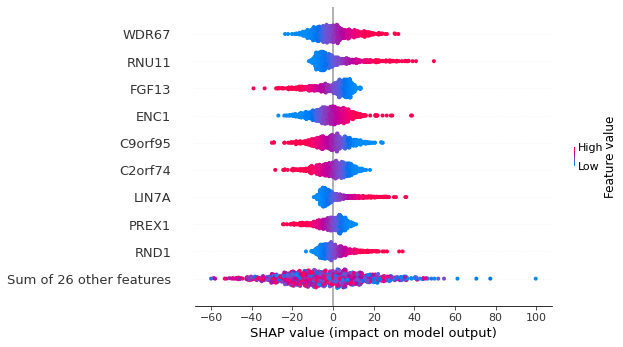

In [40]:
# load JS visualization code to notebook
shap.initjs()
# Create object that can calculate shap values
explainer = shap.Explainer(svm, X_train, feature_names=X_train.columns)
shap_values = explainer(X_train)
shap.plots.beeswarm(shap_values)

## lightGBM

In [41]:
params = {
    "lambda_l1": 2.3140471298414025,
    "lambda_l2": 2.8001110203753297,
    "max_bin": 283,
    "num_leaves": 20,
    "learning_rate": 0.01727053317047955,
    "n_estimators": 351,
    "class_weight": "balanced",
    "random_state": SEED,
}
gbm = LGBMClassifier(**params)

gbm.fit(X_train, y_train)
y_pred = gbm.predict(X_test)

show_scores(y_test, y_pred)

[LightGBM] [Warning] lambda_l1 is set=2.3140471298414025, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3140471298414025
[LightGBM] [Warning] lambda_l2 is set=2.8001110203753297, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8001110203753297
accuracy:  0.6886792452830188
precision:  0.7142857142857143
recall:  0.7017543859649122
f1 score:  0.7079646017699114


 93%|=================== | 881/950 [00:11<00:00]       

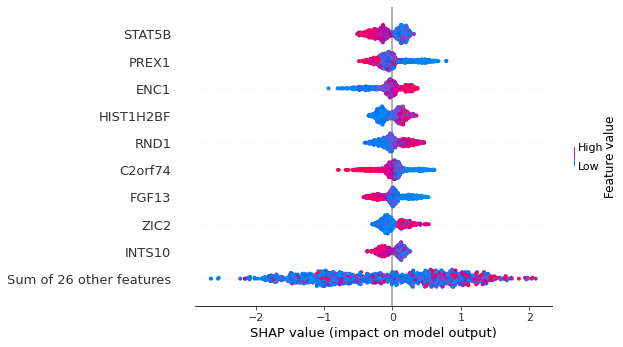

In [42]:
# load JS visualization code to notebook
shap.initjs()
# Create object that can calculate shap values
explainer = shap.Explainer(gbm, X_train, feature_names=X_train.columns)
shap_values = explainer(X_train)
shap.plots.beeswarm(shap_values)

# create ML model and interpret ML model (each subtypes)

In [47]:
dict_subtype_params = pickle_load(
    config.INTERIM_PICKLE_TUNING_PROGNOSIS_CROSS_DIR + "/subtype_params.pickle"
)

In [60]:
def prediction_subtype(ml_model: callable, ml_name: str):
    subtypes = [
        "claudin-low",
        "LumA",
        "LumB",
        "Her2",
        "Normal",
        "Basal",
    ]

    for year in range(15, 16, 5):  # 予後年数毎のループ
        print("====={0:0=2}".format(year) * 10)
        for subtype in subtypes:
            print("----------" * 10)
            print(subtype)
            prognosis_Xlabel = "X{0:0=2}_{1}".format(year, subtype)
            prognosis_ylabel = "y{0:0=2}_{1}".format(year, subtype)
            X_train_subtype = X_dict["genes"]["claudin_subtype"]["mrmr"]["train"][
                prognosis_Xlabel
            ]
            y_train_subtype = y_dict["genes"]["claudin_subtype"]["mrmr"]["train"][
                prognosis_ylabel
            ]
            X_val_subtype = X_dict["genes"]["claudin_subtype"]["mrmr"]["val"][
                prognosis_Xlabel
            ]
            y_val_subtype = y_dict["genes"]["claudin_subtype"]["mrmr"]["val"][
                prognosis_ylabel
            ]
            X_test_subtype = X_dict["genes"]["claudin_subtype"]["mrmr"]["test"][
                prognosis_Xlabel
            ]
            y_test_subtype = y_dict["genes"]["claudin_subtype"]["mrmr"]["test"][
                prognosis_ylabel
            ]

            assert (
                X_train_subtype.shape[0] == y_train_subtype.shape[0]
            ), "train size is incorrect"
            assert (
                X_val_subtype.shape[0] == y_val_subtype.shape[0]
            ), "val size is incorrect"
            assert (
                X_test_subtype.shape[0] == y_test_subtype.shape[0]
            ), "test size is incorrect"

            X_train_subtype = pd.concat([X_train_subtype, X_val_subtype])
            y_train_subtype = pd.concat([y_train_subtype, y_val_subtype])
            assert (
                X_train_subtype.shape[1] == X_test_subtype.shape[1]
            ), "feature size is incorrect"

            # accuracyの表示
            print("使用特徴量：", X_train_subtype.columns)
            print("学習サンプルサイズ：", X_train_subtype.shape)
            display("ラベル比率：", y_train_subtype.value_counts())

            # over sampling
            """
            sm = SMOTE()
            X_train_subtype, y_train_subtype = sm.fit_resample(
                X_train_subtype, y_train_subtype
            )"""

            # ML model params setting
            params = dict_subtype_params[ml_name][subtype][year]
            params["class_weight"] = "balanced"
            params["random_state"] = SEED

            # ML model
            clf = ml_model(**params)
            clf.fit(X_train_subtype, y_train_subtype)  # train
            y_pred_subtype = clf.predict(X_test_subtype)  # prediction

            print(show_scores(y_test_subtype, y_pred_subtype))

In [61]:
prediction_subtype(RandomForestClassifier, "rf")

=====15=====15=====15=====15=====15=====15=====15=====15=====15=====15
----------------------------------------------------------------------------------------------------
claudin-low
使用特徴量： Index(['COBL', 'DUSP28', 'S100P', 'F7', 'PLEKHB2', 'GRAMD4', 'HIST1H4J',
       'PAXIP1', 'SUCLG2', 'MYOZ1', 'C6orf130', 'HIST1H2BF', 'CREBZF', 'DEGS1',
       'HADH', 'GUCY1A2', 'SHANK2', 'SMARCC1', 'RRNAD1', 'SNRPB2'],
      dtype='object')
学習サンプルサイズ： (98, 20)


'ラベル比率：'

0    56
1    42
Name: OS_15years, dtype: int64

accuracy:  0.7272727272727273
precision:  1.0
recall:  0.4
f1 score:  0.5714285714285715
None
----------------------------------------------------------------------------------------------------
LumA
使用特徴量： Index(['S100P', 'TOMM7', 'CCNL1', 'KIAA0040', 'HIST1H4C', 'ZIC2', 'SCMH1',
       'IL20RA', 'SPATA18', 'LSR', 'BC042566', 'APOBEC3A', 'CPA6', 'STAT5B',
       'FAM13A', 'TMEM26', 'AK3', 'ANGPT2', 'BEX1', 'FGF13'],
      dtype='object')
学習サンプルサイズ： (305, 20)


'ラベル比率：'

0    192
1    113
Name: OS_15years, dtype: int64

accuracy:  0.7058823529411765
precision:  0.6666666666666666
recall:  0.46153846153846156
f1 score:  0.5454545454545455
None
----------------------------------------------------------------------------------------------------
LumB
使用特徴量： Index(['ENC1', 'CARS', 'F12', 'EDN3', 'ESYT2', 'CARD10', 'ACO1', 'CELSR2',
       'TP53BP2', 'ZFX', 'C11orf54', 'CYP4F8', 'GCDH', 'ARGLU1', 'C9orf95',
       'PGBD5', 'STOML2', 'SLC7A2', 'RHOG', 'LSS'],
      dtype='object')
学習サンプルサイズ： (234, 20)


'ラベル比率：'

1    153
0     81
Name: OS_15years, dtype: int64

accuracy:  0.6666666666666666
precision:  0.6956521739130435
recall:  0.8888888888888888
f1 score:  0.7804878048780488
None
----------------------------------------------------------------------------------------------------
Her2
使用特徴量： Index(['DKFZp667P0924', 'HLA-DQB1', 'NEFH', 'NECAB1', 'ATP6V1C2', 'TM4SF1',
       'PKIB', 'SHMT1', 'MAP6D1', 'WARS2', 'PRR15L', 'PCDH20', 'ABCA4',
       'RABL2B', 'MICAL1', 'C11orf80', 'WASF3', 'FAM184A', 'MAGEA4', 'PARP3'],
      dtype='object')
学習サンプルサイズ： (135, 20)


'ラベル比率：'

1    93
0    42
Name: OS_15years, dtype: int64

accuracy:  0.4666666666666667
precision:  0.5833333333333334
recall:  0.7
f1 score:  0.6363636363636365
None
----------------------------------------------------------------------------------------------------
Normal
使用特徴量： Index(['IFT88', 'RAB27B', 'SLAIN1', 'GAS7', 'C6orf165', 'LLGL1', 'RAB36',
       'PNLDC1', 'KIF13B', 'LOC389033', 'ZFAND2A', 'INTS3', 'LRP2', 'SESN1',
       'MIPEP', 'ANKRD57', 'ARSG', 'PSMD12', 'MYO6', 'PIR'],
      dtype='object')
学習サンプルサイズ： (63, 20)


'ラベル比率：'

1    38
0    25
Name: OS_15years, dtype: int64

accuracy:  0.42857142857142855
precision:  0.5
recall:  0.75
f1 score:  0.6
None
----------------------------------------------------------------------------------------------------
Basal
使用特徴量： Index(['C16orf61', 'CTSH', 'PIGV', 'PDK3', 'BMP1', 'ACOT9', 'HES1', 'CXCL13',
       'SLC39A8', 'MEGF10', 'TIMP1', 'TRIP6', 'KLHL13', 'NOS3', 'FBXO31',
       'IFT27', 'C20orf201', 'MYST4', 'SLC7A5', 'PTHLH'],
      dtype='object')
学習サンプルサイズ： (114, 20)


'ラベル比率：'

1    69
0    45
Name: OS_15years, dtype: int64

accuracy:  0.46153846153846156
precision:  0.5555555555555556
recall:  0.625
f1 score:  0.5882352941176471
None


## RandomForest

In [55]:
subtypes = [
    "claudin-low",
    "LumA",
    "LumB",
    "Her2",
    "Normal",
    "Basal",
]


for year in range(15, 16, 5):  # 予後年数毎のループ
    print("====={0:0=2}".format(year) * 10)
    for subtype in subtypes:
        print("----------" * 10)
        print(subtype)
        prognosis_Xlabel = "X{0:0=2}_{1}".format(year, subtype)
        prognosis_ylabel = "y{0:0=2}_{1}".format(year, subtype)
        X_train_subtype = X_dict["genes"]["claudin_subtype"]["mrmr"]["train"][
            prognosis_Xlabel
        ]
        y_train_subtype = y_dict["genes"]["claudin_subtype"]["mrmr"]["train"][
            prognosis_ylabel
        ]
        X_val_subtype = X_dict["genes"]["claudin_subtype"]["mrmr"]["val"][
            prognosis_Xlabel
        ]
        y_val_subtype = y_dict["genes"]["claudin_subtype"]["mrmr"]["val"][
            prognosis_ylabel
        ]
        X_test_subtype = X_dict["genes"]["claudin_subtype"]["mrmr"]["test"][
            prognosis_Xlabel
        ]
        y_test_subtype = y_dict["genes"]["claudin_subtype"]["mrmr"]["test"][
            prognosis_ylabel
        ]

        assert (
            X_train_subtype.shape[0] == y_train_subtype.shape[0]
        ), "train size is incorrect"
        assert X_val_subtype.shape[0] == y_val_subtype.shape[0], "val size is incorrect"
        assert (
            X_test_subtype.shape[0] == y_test_subtype.shape[0]
        ), "test size is incorrect"

        X_train_subtype = pd.concat([X_train_subtype, X_val_subtype])
        y_train_subtype = pd.concat([y_train_subtype, y_val_subtype])
        assert (
            X_train_subtype.shape[1] == X_test_subtype.shape[1]
        ), "feature size is incorrect"

        # accuracyの表示
        print("使用特徴量：", X_train_subtype.columns)
        print("学習サンプルサイズ：", X_train_subtype.shape)
        display("ラベル比率：", y_train_subtype.value_counts())

        # over sampling
        """
        sm = SMOTE()
        X_train_subtype, y_train_subtype = sm.fit_resample(
            X_train_subtype, y_train_subtype
        )"""

        # ML model params setting
        params = dict_subtype_params["rf"][subtype][year]
        params["class_weight"] = "balanced"
        params["random_state"] = SEED

        # ML model
        clf = RandomForestClassifier(**params)
        clf.fit(X_train_subtype, y_train_subtype)  # train
        y_pred_subtype = clf.predict(X_test_subtype)  # prediction

        print(show_scores(y_test_subtype, y_pred_subtype))

=====15=====15=====15=====15=====15=====15=====15=====15=====15=====15
----------------------------------------------------------------------------------------------------
claudin-low
使用特徴量： Index(['COBL', 'DUSP28', 'S100P', 'F7', 'PLEKHB2', 'GRAMD4', 'HIST1H4J',
       'PAXIP1', 'SUCLG2', 'MYOZ1', 'C6orf130', 'HIST1H2BF', 'CREBZF', 'DEGS1',
       'HADH', 'GUCY1A2', 'SHANK2', 'SMARCC1', 'RRNAD1', 'SNRPB2'],
      dtype='object')
学習サンプルサイズ： (98, 20)


'ラベル比率：'

0    56
1    42
Name: OS_15years, dtype: int64

accuracy:  0.7272727272727273
precision:  1.0
recall:  0.4
f1 score:  0.5714285714285715
None
----------------------------------------------------------------------------------------------------
LumA
使用特徴量： Index(['S100P', 'TOMM7', 'CCNL1', 'KIAA0040', 'HIST1H4C', 'ZIC2', 'SCMH1',
       'IL20RA', 'SPATA18', 'LSR', 'BC042566', 'APOBEC3A', 'CPA6', 'STAT5B',
       'FAM13A', 'TMEM26', 'AK3', 'ANGPT2', 'BEX1', 'FGF13'],
      dtype='object')
学習サンプルサイズ： (305, 20)


'ラベル比率：'

0    192
1    113
Name: OS_15years, dtype: int64

accuracy:  0.7058823529411765
precision:  0.6666666666666666
recall:  0.46153846153846156
f1 score:  0.5454545454545455
None
----------------------------------------------------------------------------------------------------
LumB
使用特徴量： Index(['ENC1', 'CARS', 'F12', 'EDN3', 'ESYT2', 'CARD10', 'ACO1', 'CELSR2',
       'TP53BP2', 'ZFX', 'C11orf54', 'CYP4F8', 'GCDH', 'ARGLU1', 'C9orf95',
       'PGBD5', 'STOML2', 'SLC7A2', 'RHOG', 'LSS'],
      dtype='object')
学習サンプルサイズ： (234, 20)


'ラベル比率：'

1    153
0     81
Name: OS_15years, dtype: int64

accuracy:  0.6666666666666666
precision:  0.6956521739130435
recall:  0.8888888888888888
f1 score:  0.7804878048780488
None
----------------------------------------------------------------------------------------------------
Her2
使用特徴量： Index(['DKFZp667P0924', 'HLA-DQB1', 'NEFH', 'NECAB1', 'ATP6V1C2', 'TM4SF1',
       'PKIB', 'SHMT1', 'MAP6D1', 'WARS2', 'PRR15L', 'PCDH20', 'ABCA4',
       'RABL2B', 'MICAL1', 'C11orf80', 'WASF3', 'FAM184A', 'MAGEA4', 'PARP3'],
      dtype='object')
学習サンプルサイズ： (135, 20)


'ラベル比率：'

1    93
0    42
Name: OS_15years, dtype: int64

accuracy:  0.4666666666666667
precision:  0.5833333333333334
recall:  0.7
f1 score:  0.6363636363636365
None
----------------------------------------------------------------------------------------------------
Normal
使用特徴量： Index(['IFT88', 'RAB27B', 'SLAIN1', 'GAS7', 'C6orf165', 'LLGL1', 'RAB36',
       'PNLDC1', 'KIF13B', 'LOC389033', 'ZFAND2A', 'INTS3', 'LRP2', 'SESN1',
       'MIPEP', 'ANKRD57', 'ARSG', 'PSMD12', 'MYO6', 'PIR'],
      dtype='object')
学習サンプルサイズ： (63, 20)


'ラベル比率：'

1    38
0    25
Name: OS_15years, dtype: int64

accuracy:  0.42857142857142855
precision:  0.5
recall:  0.75
f1 score:  0.6
None
----------------------------------------------------------------------------------------------------
Basal
使用特徴量： Index(['C16orf61', 'CTSH', 'PIGV', 'PDK3', 'BMP1', 'ACOT9', 'HES1', 'CXCL13',
       'SLC39A8', 'MEGF10', 'TIMP1', 'TRIP6', 'KLHL13', 'NOS3', 'FBXO31',
       'IFT27', 'C20orf201', 'MYST4', 'SLC7A5', 'PTHLH'],
      dtype='object')
学習サンプルサイズ： (114, 20)


'ラベル比率：'

1    69
0    45
Name: OS_15years, dtype: int64

accuracy:  0.46153846153846156
precision:  0.5555555555555556
recall:  0.625
f1 score:  0.5882352941176471
None


## LogitsticRegression

In [58]:
subtypes = [
    "claudin-low",
    "LumA",
    "LumB",
    "Her2",
    "Normal",
    "Basal",
]


for year in range(15, 16, 5):  # 予後年数毎のループ
    print("====={0:0=2}".format(year) * 10)
    for subtype in subtypes:
        print("----------" * 10)
        print(subtype)
        prognosis_Xlabel = "X{0:0=2}_{1}".format(year, subtype)
        prognosis_ylabel = "y{0:0=2}_{1}".format(year, subtype)
        X_train_subtype = X_dict["genes"]["claudin_subtype"]["mrmr"]["train"][
            prognosis_Xlabel
        ]
        y_train_subtype = y_dict["genes"]["claudin_subtype"]["mrmr"]["train"][
            prognosis_ylabel
        ]
        X_val_subtype = X_dict["genes"]["claudin_subtype"]["mrmr"]["val"][
            prognosis_Xlabel
        ]
        y_val_subtype = y_dict["genes"]["claudin_subtype"]["mrmr"]["val"][
            prognosis_ylabel
        ]
        X_test_subtype = X_dict["genes"]["claudin_subtype"]["mrmr"]["test"][
            prognosis_Xlabel
        ]
        y_test_subtype = y_dict["genes"]["claudin_subtype"]["mrmr"]["test"][
            prognosis_ylabel
        ]

        assert (
            X_train_subtype.shape[0] == y_train_subtype.shape[0]
        ), "train size is incorrect"
        assert X_val_subtype.shape[0] == y_val_subtype.shape[0], "val size is incorrect"
        assert (
            X_test_subtype.shape[0] == y_test_subtype.shape[0]
        ), "test size is incorrect"

        X_train_subtype = pd.concat([X_train_subtype, X_val_subtype])
        y_train_subtype = pd.concat([y_train_subtype, y_val_subtype])
        assert (
            X_train_subtype.shape[1] == X_test_subtype.shape[1]
        ), "feature size is incorrect"

        # accuracyの表示
        print("使用特徴量：", X_train_subtype.columns)
        print("学習サンプルサイズ：", X_train_subtype.shape)
        display("ラベル比率：", y_train_subtype.value_counts())

        # over sampling

        sm = SMOTE()
        X_train_subtype, y_train_subtype = sm.fit_resample(
            X_train_subtype, y_train_subtype
        )

        # ML model params setting
        params = dict_subtype_params["lr"][subtype][year]
        params["class_weight"] = "balanced"
        params["random_state"] = SEED

        # ML model
        clf = LogisticRegression(**params)
        clf.fit(X_train_subtype, y_train_subtype)  # train
        y_pred_subtype = clf.predict(X_test_subtype)  # prediction

        print(show_scores(y_test_subtype, y_pred_subtype))

=====15=====15=====15=====15=====15=====15=====15=====15=====15=====15
----------------------------------------------------------------------------------------------------
claudin-low
使用特徴量： Index(['COBL', 'DUSP28', 'S100P', 'F7', 'PLEKHB2', 'GRAMD4', 'HIST1H4J',
       'PAXIP1', 'SUCLG2', 'MYOZ1', 'C6orf130', 'HIST1H2BF', 'CREBZF', 'DEGS1',
       'HADH', 'GUCY1A2', 'SHANK2', 'SMARCC1', 'RRNAD1', 'SNRPB2'],
      dtype='object')
学習サンプルサイズ： (98, 20)


'ラベル比率：'

0    56
1    42
Name: OS_15years, dtype: int64

accuracy:  0.6363636363636364
precision:  1.0
recall:  0.2
f1 score:  0.33333333333333337
None
----------------------------------------------------------------------------------------------------
LumA
使用特徴量： Index(['S100P', 'TOMM7', 'CCNL1', 'KIAA0040', 'HIST1H4C', 'ZIC2', 'SCMH1',
       'IL20RA', 'SPATA18', 'LSR', 'BC042566', 'APOBEC3A', 'CPA6', 'STAT5B',
       'FAM13A', 'TMEM26', 'AK3', 'ANGPT2', 'BEX1', 'FGF13'],
      dtype='object')
学習サンプルサイズ： (305, 20)


'ラベル比率：'

0    192
1    113
Name: OS_15years, dtype: int64

accuracy:  0.6470588235294118
precision:  0.5384615384615384
recall:  0.5384615384615384
f1 score:  0.5384615384615384
None
----------------------------------------------------------------------------------------------------
LumB
使用特徴量： Index(['ENC1', 'CARS', 'F12', 'EDN3', 'ESYT2', 'CARD10', 'ACO1', 'CELSR2',
       'TP53BP2', 'ZFX', 'C11orf54', 'CYP4F8', 'GCDH', 'ARGLU1', 'C9orf95',
       'PGBD5', 'STOML2', 'SLC7A2', 'RHOG', 'LSS'],
      dtype='object')
学習サンプルサイズ： (234, 20)


'ラベル比率：'

1    153
0     81
Name: OS_15years, dtype: int64

accuracy:  0.7407407407407407
precision:  0.8235294117647058
recall:  0.7777777777777778
f1 score:  0.7999999999999999
None
----------------------------------------------------------------------------------------------------
Her2
使用特徴量： Index(['DKFZp667P0924', 'HLA-DQB1', 'NEFH', 'NECAB1', 'ATP6V1C2', 'TM4SF1',
       'PKIB', 'SHMT1', 'MAP6D1', 'WARS2', 'PRR15L', 'PCDH20', 'ABCA4',
       'RABL2B', 'MICAL1', 'C11orf80', 'WASF3', 'FAM184A', 'MAGEA4', 'PARP3'],
      dtype='object')
学習サンプルサイズ： (135, 20)


'ラベル比率：'

1    93
0    42
Name: OS_15years, dtype: int64

accuracy:  0.5333333333333333
precision:  0.6666666666666666
recall:  0.6
f1 score:  0.631578947368421
None
----------------------------------------------------------------------------------------------------
Normal
使用特徴量： Index(['IFT88', 'RAB27B', 'SLAIN1', 'GAS7', 'C6orf165', 'LLGL1', 'RAB36',
       'PNLDC1', 'KIF13B', 'LOC389033', 'ZFAND2A', 'INTS3', 'LRP2', 'SESN1',
       'MIPEP', 'ANKRD57', 'ARSG', 'PSMD12', 'MYO6', 'PIR'],
      dtype='object')
学習サンプルサイズ： (63, 20)


'ラベル比率：'

1    38
0    25
Name: OS_15years, dtype: int64

accuracy:  0.42857142857142855
precision:  0.5
recall:  0.75
f1 score:  0.6
None
----------------------------------------------------------------------------------------------------
Basal
使用特徴量： Index(['C16orf61', 'CTSH', 'PIGV', 'PDK3', 'BMP1', 'ACOT9', 'HES1', 'CXCL13',
       'SLC39A8', 'MEGF10', 'TIMP1', 'TRIP6', 'KLHL13', 'NOS3', 'FBXO31',
       'IFT27', 'C20orf201', 'MYST4', 'SLC7A5', 'PTHLH'],
      dtype='object')
学習サンプルサイズ： (114, 20)


'ラベル比率：'

1    69
0    45
Name: OS_15years, dtype: int64

accuracy:  0.38461538461538464
precision:  0.5
recall:  0.5
f1 score:  0.5
None


## LightGBM

In [59]:
subtypes = [
    "claudin-low",
    "LumA",
    "LumB",
    "Her2",
    "Normal",
    "Basal",
]


for year in range(15, 16, 5):  # 予後年数毎のループ
    print("====={0:0=2}".format(year) * 10)
    for subtype in subtypes:
        print("----------" * 10)
        print(subtype)
        prognosis_Xlabel = "X{0:0=2}_{1}".format(year, subtype)
        prognosis_ylabel = "y{0:0=2}_{1}".format(year, subtype)
        X_train_subtype = X_dict["genes"]["claudin_subtype"]["mrmr"]["train"][
            prognosis_Xlabel
        ]
        y_train_subtype = y_dict["genes"]["claudin_subtype"]["mrmr"]["train"][
            prognosis_ylabel
        ]
        X_val_subtype = X_dict["genes"]["claudin_subtype"]["mrmr"]["val"][
            prognosis_Xlabel
        ]
        y_val_subtype = y_dict["genes"]["claudin_subtype"]["mrmr"]["val"][
            prognosis_ylabel
        ]
        X_test_subtype = X_dict["genes"]["claudin_subtype"]["mrmr"]["test"][
            prognosis_Xlabel
        ]
        y_test_subtype = y_dict["genes"]["claudin_subtype"]["mrmr"]["test"][
            prognosis_ylabel
        ]

        assert (
            X_train_subtype.shape[0] == y_train_subtype.shape[0]
        ), "train size is incorrect"
        assert X_val_subtype.shape[0] == y_val_subtype.shape[0], "val size is incorrect"
        assert (
            X_test_subtype.shape[0] == y_test_subtype.shape[0]
        ), "test size is incorrect"

        X_train_subtype = pd.concat([X_train_subtype, X_val_subtype])
        y_train_subtype = pd.concat([y_train_subtype, y_val_subtype])
        assert (
            X_train_subtype.shape[1] == X_test_subtype.shape[1]
        ), "feature size is incorrect"

        # accuracyの表示
        print("使用特徴量：", X_train_subtype.columns)
        print("学習サンプルサイズ：", X_train_subtype.shape)
        display("ラベル比率：", y_train_subtype.value_counts())

        # over sampling
        """
        sm = SMOTE()
        X_train_subtype, y_train_subtype = sm.fit_resample(
            X_train_subtype, y_train_subtype
        )"""

        # ML model params setting
        params = dict_subtype_params["rf"][subtype][year]
        params["class_weight"] = "balanced"
        params["random_state"] = SEED

        # ML model
        clf = LGBMClassifier(**params)
        clf.fit(X_train_subtype, y_train_subtype)  # train
        y_pred_subtype = clf.predict(X_test_subtype)  # prediction

        print(show_scores(y_test_subtype, y_pred_subtype))

=====15=====15=====15=====15=====15=====15=====15=====15=====15=====15
----------------------------------------------------------------------------------------------------
claudin-low
使用特徴量： Index(['COBL', 'DUSP28', 'S100P', 'F7', 'PLEKHB2', 'GRAMD4', 'HIST1H4J',
       'PAXIP1', 'SUCLG2', 'MYOZ1', 'C6orf130', 'HIST1H2BF', 'CREBZF', 'DEGS1',
       'HADH', 'GUCY1A2', 'SHANK2', 'SMARCC1', 'RRNAD1', 'SNRPB2'],
      dtype='object')
学習サンプルサイズ： (98, 20)


'ラベル比率：'

0    56
1    42
Name: OS_15years, dtype: int64

[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=9 will be ignored. Current value: num_leaves=31
accuracy:  0.7272727272727273
precision:  0.75
recall:  0.6
f1 score:  0.6666666666666665
None
----------------------------------------------------------------------------------------------------
LumA
使用特徴量： Index(['S100P', 'TOMM7', 'CCNL1', 'KIAA0040', 'HIST1H4C', 'ZIC2', 'SCMH1',
       'IL20RA', 'SPATA18', 'LSR', 'BC042566', 'APOBEC3A', 'CPA6', 'STAT5B',
       'FAM13A', 'TMEM26', 'AK3', 'ANGPT2', 'BEX1', 'FGF13'],
      dtype='object')
学習サンプルサイズ： (305, 20)


'ラベル比率：'

0    192
1    113
Name: OS_15years, dtype: int64

[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=35 will be ignored. Current value: num_leaves=31
accuracy:  0.6176470588235294
precision:  0.5
recall:  0.46153846153846156
f1 score:  0.48000000000000004
None
----------------------------------------------------------------------------------------------------
LumB
使用特徴量： Index(['ENC1', 'CARS', 'F12', 'EDN3', 'ESYT2', 'CARD10', 'ACO1', 'CELSR2',
       'TP53BP2', 'ZFX', 'C11orf54', 'CYP4F8', 'GCDH', 'ARGLU1', 'C9orf95',
       'PGBD5', 'STOML2', 'SLC7A2', 'RHOG', 'LSS'],
      dtype='object')
学習サンプルサイズ： (234, 20)


'ラベル比率：'

1    153
0     81
Name: OS_15years, dtype: int64

[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=81 will be ignored. Current value: num_leaves=31
accuracy:  0.6296296296296297
precision:  0.7
recall:  0.7777777777777778
f1 score:  0.7368421052631577
None
----------------------------------------------------------------------------------------------------
Her2
使用特徴量： Index(['DKFZp667P0924', 'HLA-DQB1', 'NEFH', 'NECAB1', 'ATP6V1C2', 'TM4SF1',
       'PKIB', 'SHMT1', 'MAP6D1', 'WARS2', 'PRR15L', 'PCDH20', 'ABCA4',
       'RABL2B', 'MICAL1', 'C11orf80', 'WASF3', 'FAM184A', 'MAGEA4', 'PARP3'],
      dtype='object')
学習サンプルサイズ： (135, 20)


'ラベル比率：'

1    93
0    42
Name: OS_15years, dtype: int64

[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=89 will be ignored. Current value: num_leaves=31
accuracy:  0.4666666666666667
precision:  0.6
recall:  0.6
f1 score:  0.6
None
----------------------------------------------------------------------------------------------------
Normal
使用特徴量： Index(['IFT88', 'RAB27B', 'SLAIN1', 'GAS7', 'C6orf165', 'LLGL1', 'RAB36',
       'PNLDC1', 'KIF13B', 'LOC389033', 'ZFAND2A', 'INTS3', 'LRP2', 'SESN1',
       'MIPEP', 'ANKRD57', 'ARSG', 'PSMD12', 'MYO6', 'PIR'],
      dtype='object')
学習サンプルサイズ： (63, 20)


'ラベル比率：'

1    38
0    25
Name: OS_15years, dtype: int64

[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=23 will be ignored. Current value: num_leaves=31
accuracy:  0.42857142857142855
precision:  0.5
recall:  0.75
f1 score:  0.6
None
----------------------------------------------------------------------------------------------------
Basal
使用特徴量： Index(['C16orf61', 'CTSH', 'PIGV', 'PDK3', 'BMP1', 'ACOT9', 'HES1', 'CXCL13',
       'SLC39A8', 'MEGF10', 'TIMP1', 'TRIP6', 'KLHL13', 'NOS3', 'FBXO31',
       'IFT27', 'C20orf201', 'MYST4', 'SLC7A5', 'PTHLH'],
      dtype='object')
学習サンプルサイズ： (114, 20)


'ラベル比率：'

1    69
0    45
Name: OS_15years, dtype: int64

[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=43 will be ignored. Current value: num_leaves=31
accuracy:  0.46153846153846156
precision:  0.5555555555555556
recall:  0.625
f1 score:  0.5882352941176471
None
